This notebook was automatically tested on the EOTDL platform with kernel **eotdl-2023.10**
<details>
    
```
    channels:
    - conda-forge
    dependencies:
    - python=3.9
    - ipykernel
    - geojson
    - ipyleaflet
    - ipywidgets
    - jupyterlab_widgets
    - jupyterlab-geojson
    - libgcc
    - papermill
    - timm
    - geomet
    - matplotlib
    - lightning
    - rioxarray
    - pystac
    - pyproj
    - mlflow
    - pip:
      - pytorch-eo==2023.7.21
      - eotdl==2023.9.14.post4
    description: ''
    name: eotdl-2023.10
    prefix: null
```
</details>

# Training with S1 images using SEN12-FLOOD dataset

In this use case, we are going to train an image classifiers with Sentinel-1 images using the SEN12-FLOOD dataset. For a training run with Sentinel-2 images please check the related [tutorial notebooks](https://notebooks.api.eotdl.com/?search=SEN12-FLOOD)!

In [1]:
import os
from pathlib import Path
path = Path(os.environ.get('EOTDL_DOWNLOAD_PATH'), 'SEN12-FLOOD')
assert(path.exists) 

> ***Note:*** the hosted [EOTDL](https://eotdl.com) platform ensures that onboarded training datasets are readily available, to access the datasets from your local machine or other platforms please check the corresponding [tutorial notebooks](https://notebooks.api.eotdl.com/?search=offline)!

In [2]:
from pytorch_eo.datasets import SEN12Floods
from pytorch_eo.datasets.sensors import Sensors, S1, S2

import lightning as L
from sklearn.metrics import average_precision_score
import albumentations as A
from pytorch_eo.tasks.classification import ImageClassification
import timm
import torch

/home/conda/users/e5f8b81ce956c8d86e2537ed7b324932f3c645dcd278e36de427953b9631b129-20230919-063146-043835-48-eotdl-2023.10/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/conda/users/e5f8b81ce956c8d86e2537ed7b324932f3c645dcd278e36de427953b9631b129-20230919-063146-043835-48-eotdl-2023.10/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Sentinel-1

First of all, let's train a image classifier using images from Sentinel-1.

In [3]:
# Resizing the images to 64x64 to plot them
trans = A.Compose([
    A.Resize(64,64)                           
])

ds = SEN12Floods(processed_data_path=path,
                 batch_size=25,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV], 
                 train_trans=trans,
                ) 

ds.setup()

Training samples 1999
Validation samples 666
Test samples 666


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [4]:
ds.df

,image,label
0,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
1,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
2,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
3,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
4,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
...,...,...
3326,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
3327,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
3328,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0
3329,/cache/datasets/SEN12-FLOOD/sen12floods_s1_sou...,0


In [5]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

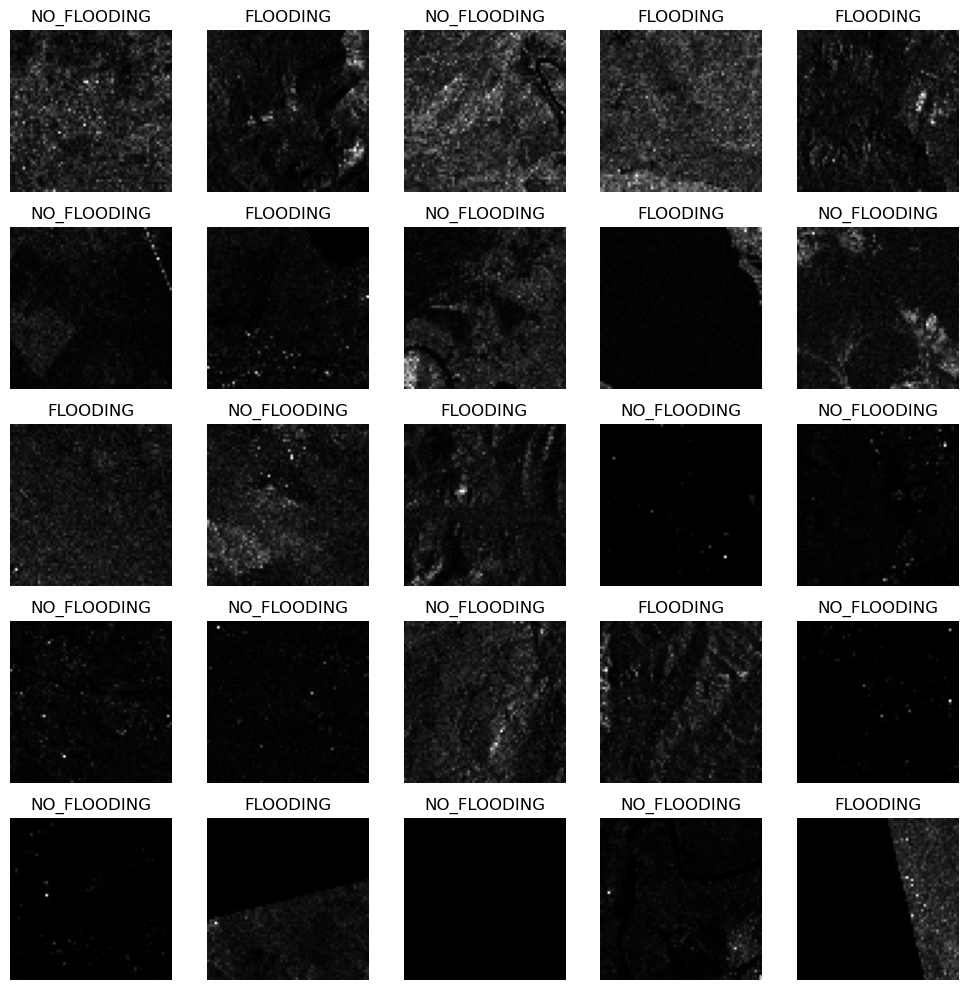

In [ ]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train our model! 

In [ ]:
ds = SEN12Floods(processed_data_path=path,
                 batch_size=64,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV],
                 pin_memory=True,
                ) 

ds.setup()

model = timm.create_model('resnet18', pretrained=True, num_classes=ds.num_classes, in_chans=ds.num_bands)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageClassification(num_classes=ds.num_classes , model=model, hparams=hparams)

trainer = L.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    max_epochs=3,
)

trainer.fit(task, ds)

Training samples 1999
Validation samples 666
Test samples 666


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/conda/users/e5f8b81ce956c8d86e2537ed7b324932f3c645dcd278e36de427953b9631b129-20230919-063146-043835-48-eotdl-2023.10/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc 

Training samples 1999
Validation samples 666
Test samples 666


Sanity Checking: 0it [00:00, ?it/s]

/home/conda/users/e5f8b81ce956c8d86e2537ed7b324932f3c645dcd278e36de427953b9631b129-20230919-063146-043835-48-eotdl-2023.10/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/conda/users/e5f8b81ce956c8d86e2537ed7b324932f3c645dcd278e36de427953b9631b129-20230919-063146-043835-48-eotdl-2023.10/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/h

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test(dataloaders=ds.test_dataloader())